<h2>Name : Anuj Jagannath Said<br>
Roll number : ME21b172</h2>

In [1]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report,f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.datasets import make_moons, make_circles
from matplotlib.colors import ListedColormap
from sklearn.svm import LinearSVC

import matplotlib.colors as colors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
params={
    'LogisticRegression' : {
        'C': [0.1, 1, 10, 100],  
        'penalty': ['l2'],  
        'solver': ['liblinear'] 
    },
    'DecisionTree' :{
        'max_depth': [3],      
        'min_samples_leaf': [1, 5, 10],     
    },
    'DecisionStump' :{
        'max_depth': [1],      
        'min_samples_leaf': [1, 5, 10],     
    },
    'LinearSVC' :{
        'C': [0.1, 10, 100], 
        'tol': [1e-4, 1e-2], 
    },
    'LDA' :{
        'solver': ['svd', 'lsqr', 'eigen'],  
        'shrinkage': [None],      
    }

}
Classifier={
    'LogisticRegression' : LogisticRegression(),
    'DecisionTree' : DecisionTreeClassifier(),
    'DecisionStump' : DecisionTreeClassifier(),
    'LinearSVC' : LinearSVC(max_iter=10000),
    'LDA' : LinearDiscriminantAnalysis(),
}


In [3]:
def predict(alphas,models,X):
    '''Predict '''
    y_pred = np.zeros(X.shape[0])
    for i in range(len(models)):
        y_pred += models[i].predict(X)*alphas[i]
    return np.where(y_pred < 0 ,-1 ,1)

def plot_decision_boundary(clf, X, y,alphas=-1,models=-1, axes=[-1.75, 1.75, -1.5, 1.5], alpha=0.5, contour=True):
    '''Helper function for plotting decision boundaries'''
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    if alphas == -1:
        y_pred = clf.predict(X_new).reshape(x1.shape)
    else:
        y_pred = predict(alphas,models,X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred,cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==-1], X[:, 1][y==-1], "y.", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "b.", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

def plottingDecisionBoundaryForEachClassifier(models,X,y):
    '''Plotting the decion boundaries'''
    for model in models:
        plot_decision_boundary(model,X,y)

def predictAccuracy(models,alphas,X,y):
    y_pred = predict(alphas=alphas,models=models,X=X)
    accuracy = np.sum(y_pred == y)/len(y_pred)
    return accuracy
def AdaBoostViaSampling(X,y,n_estimators,model='DecisionTree',eta=0.5):  # X is n*d matrix
    '''Implementing Adaboost algorithm'''
    weights = []
    alphas = []
    models = []
    number_of_samples = 90
    weights.append(np.ones(X.shape[0])*(1/X.shape[0]))
    for t in range(n_estimators):
        # Creating and Predicting on samples genrated using previous weights
        samples = np.random.choice(np.arange(0, len(y)), p=weights[-1],size=number_of_samples)
        X_prime = X[samples]
        y_prime = y[samples]
        # Performing Cross validation
        crossValidation = GridSearchCV(Classifier[model],params[model]).fit(X_prime,y_prime)
        models.append(crossValidation.best_estimator_)
        y_pred = crossValidation.best_estimator_.predict(X)
        error = np.sum((y != y_pred)*weights[-1])
        # Handling zero error case
        if error ==0:
            error = 1e-18
        alphas.append(eta*np.log((1-error)/(error)))
        weight = weights[-1]*np.exp(-y_pred*y*alphas[-1])
        weights.append(weight/np.sum(weight))
    return alphas,models

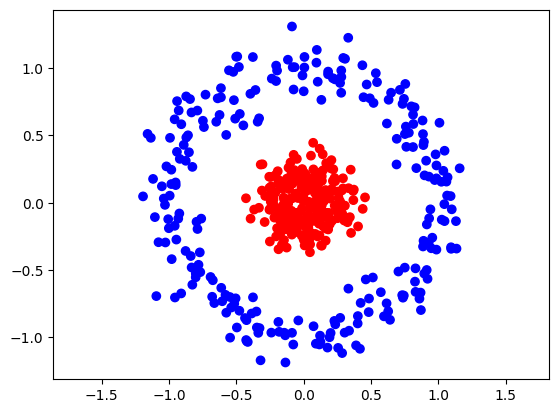

In [4]:
X, y = make_circles(n_samples=500, noise=0.1, random_state=42, factor=0.2)
y = np.where(y == 0 ,-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
plt.scatter(X[:,0], X[:,1], c=y, cmap=colors.ListedColormap(["blue", "red"]))
plt.axis('equal')
plt.show()

<h2>Q1</h2>

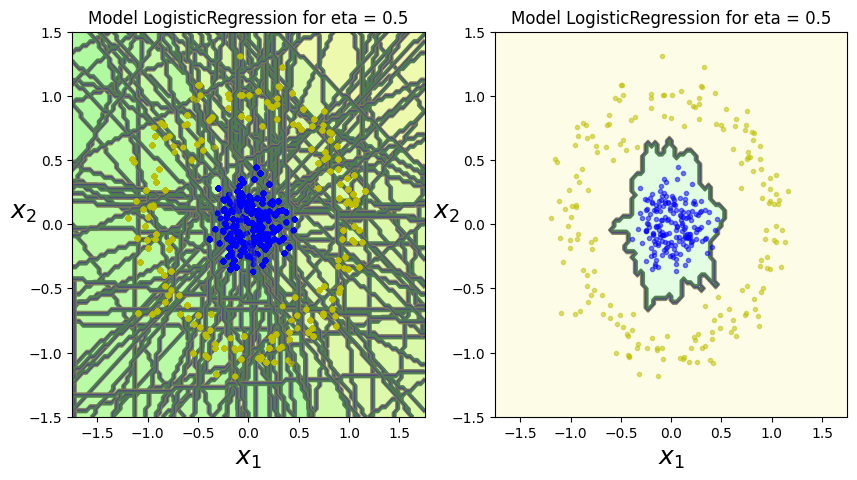

In [9]:
model = 'LogisticRegression'
# classifier fit at every iteration

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Model '+model+' for eta = 0.5')
alphas,models = AdaBoostViaSampling(X=X_train,y=y_train,n_estimators=100,model=model)
plottingDecisionBoundaryForEachClassifier(models=models,X=X_train,y=y_train)
# final ensembled classifier decision boundary
plt.subplot(1,2,2)
plt.title('Model '+model+' for eta = 0.5')
plot_decision_boundary(-1,X_train,y_train,alphas=alphas,models=models)
plt.show()

In [6]:
# y_pred = predict(alphas=alphas,models=models,X=X_test)
accuracy = predictAccuracy(models=models,alphas=alphas,X=X_test,y=y_test)
print("Accuracy of ensembled "+model+" classifier turns out to be "+str(accuracy))

Accuracy of ensembled LogisticRegression classifier turns out to be 0.992


<h2>Q2</h2>

In [7]:
modelsToBeTrained = list(Classifier.keys())
etas = np.arange(0.2,1.2,0.2)
Accuracies = []
Models = []
Alphas = []
Etas = []
for model in modelsToBeTrained:
    optimalAccuracy,optimalEta,optimalModel,optimalAlphas = (0,0,None,None)
    for eta in etas:
        alphas,models = AdaBoostViaSampling(X=X_train,y=y_train,n_estimators=100,model=model)
        accuracy = predictAccuracy(models=models,alphas=alphas,X=X_test,y=y_test)
        if accuracy > optimalAccuracy:
            optimalAccuracy,optimalEta,optimalModel,optimalAlphas = (accuracy,eta,models,alphas)
    Accuracies.append(optimalAccuracy)
    Models.append(optimalModel)
    Alphas.append(optimalAlphas)
    Etas.append(optimalEta)

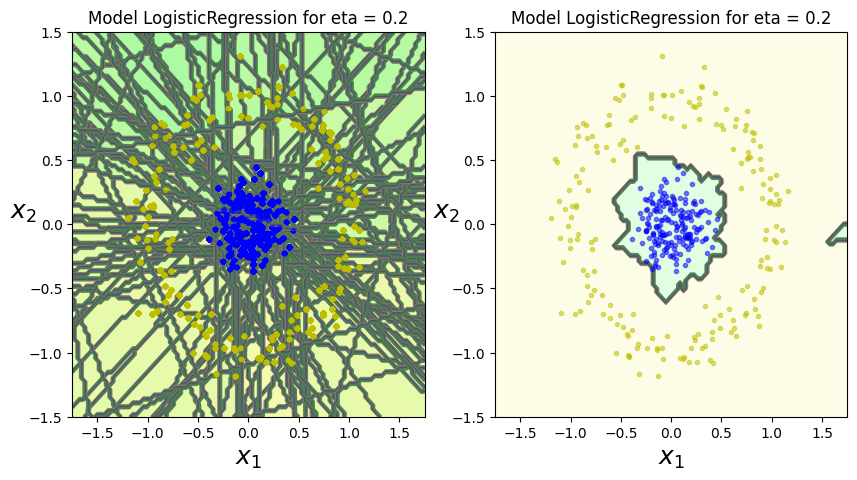

Accuracy of ensembled LogisticRegression classifier turns out to be 1.0


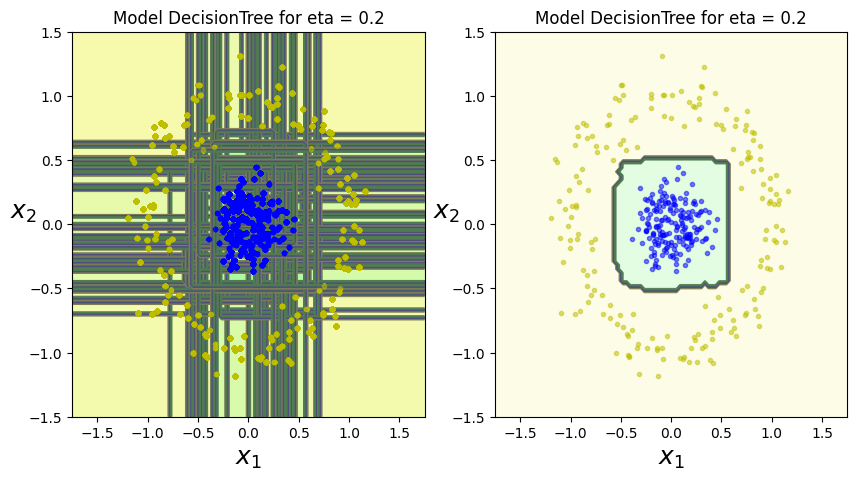

Accuracy of ensembled DecisionTree classifier turns out to be 1.0


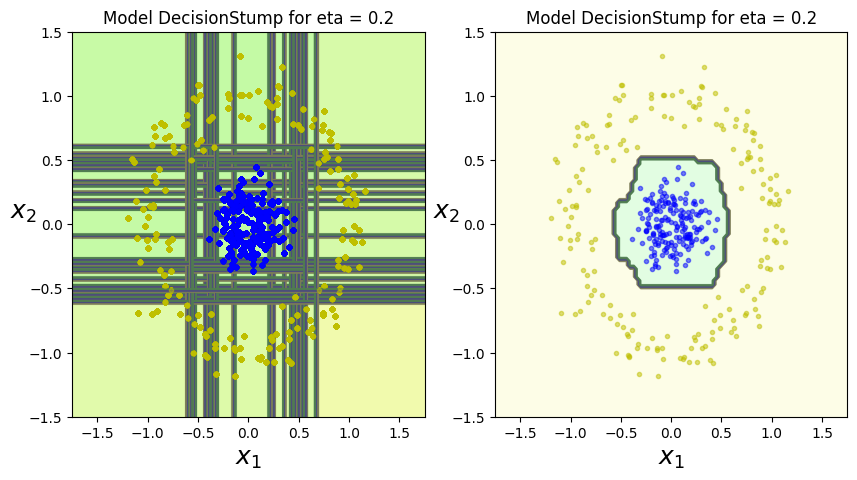

Accuracy of ensembled DecisionStump classifier turns out to be 1.0


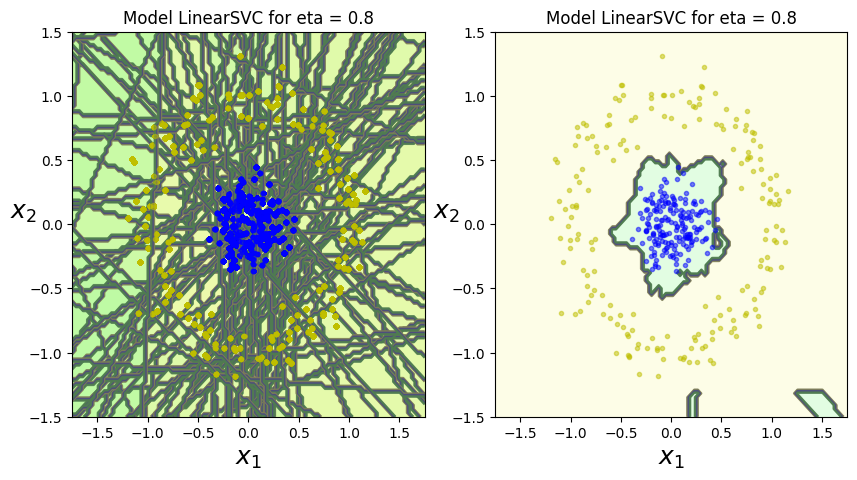

Accuracy of ensembled LinearSVC classifier turns out to be 1.0


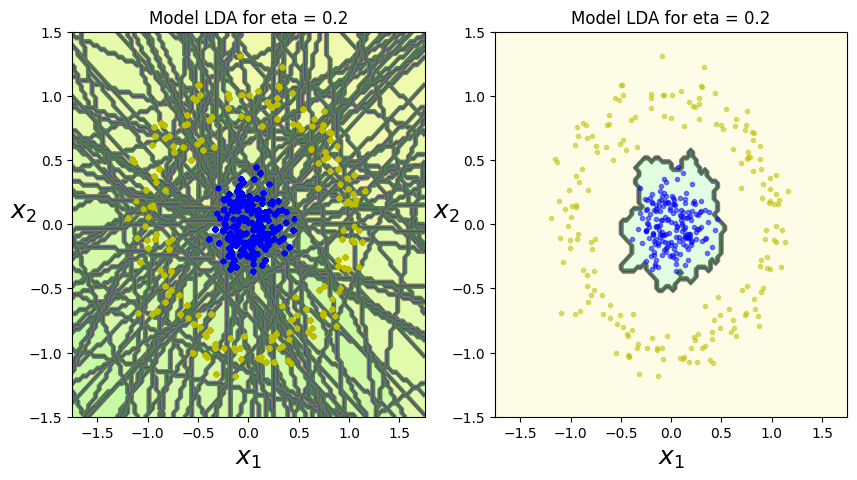

Accuracy of ensembled LDA classifier turns out to be 1.0


In [8]:
for i in range(len(Accuracies)):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 2)
    plt.title('Model '+modelsToBeTrained[i]+' for eta = '+str(Etas[i]))
    plot_decision_boundary(-1,X_train,y_train,alphas=Alphas[i],models=Models[i])
    plt.subplot(1, 2, 1)
    plt.title('Model '+modelsToBeTrained[i]+' for eta = '+str(Etas[i]))
    plottingDecisionBoundaryForEachClassifier(models=Models[i],X=X_train,y=y_train)
    plt.show()
    print("Accuracy of ensembled "+modelsToBeTrained[i]+" classifier turns out to be "+str(Accuracies[i]))